In [6]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

In [1]:
with open('../data/posts.txt') as input_file:
    posts = input_file.read()[:-1].split('---')

In [4]:
len(posts)

138

In [8]:
sentences = []
for post in posts:
    sentences.extend(post.split('\n'))

In [10]:
len(sentences)

1959

In [12]:
sentences = [sentence for sentence in sentences if sentence != '']

In [13]:
len(sentences)

1244

(array([637., 238., 151., 108.,  51.,  27.,  19.,   9.,   2.,   2.]),
 array([  2. ,  72.8, 143.6, 214.4, 285.2, 356. , 426.8, 497.6, 568.4,
        639.2, 710. ]),
 <a list of 10 Patch objects>)

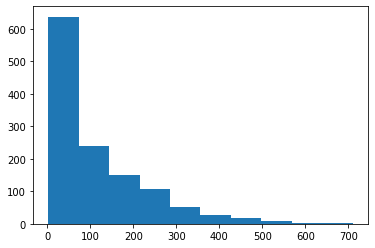

In [15]:
plt.hist(list(map(len, sentences)))

In [56]:
#all unique characters go here
tokens = list(set(' '.join(sentences).lower().split()))

num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

num_tokens =  6796


In [57]:
tokens.append(' ')

In [58]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [59]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [64]:
def to_matrix(data, token_to_id, max_len=None, dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id[' ']

    for i in range(len(data)):
        line_ix = [token_to_id[c] for c in data[i].lower().split()]
        data_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

In [65]:
#Example: cast 4 names to matrices, pad with zeros
print('\n'.join(sentences[::2000]))
print(to_matrix(sentences[::2000], token_to_id))

Привет, меня зовут Дима! Моя цель - стать учёным в области искусственного интеллекта. У меня есть план как достичь этого (его я распишу позднее), а здесь я буду вести публичный дневник, где буду делиться своими результатами, всякими интересными материалами, а также делать популярный пересказ того, чему научился за день.
[[5005 1735 1749 2648 2672  938  656 2180 6140 5918 4716 2839  788  515
  1735 5910 3723  159 4554 2148 5919 3745 5562 4302 3760 4018 3745 1975
  4865  999 2623 3376 1975 5026 4135 5756 6697 3244 3175 3760 5593 5351
   132 5356 4243 6064 5332 1399 2910 6796 6796 6796 6796 6796 6796 6796
  6796 6796 6796 6796 6796 6796 6796 6796 6796 6796 6796 6796 6796 6796
  6796 6796 6796 6796 6796 6796 6796 6796 6796 6796 6796 6796 6796 6796
  6796 6796 6796 6796 6796 6796 6796 6796 6796 6796 6796 6796 6796 6796
  6796 6796 6796 6796 6796 6796 6796 6796 6796 6796 6796 6796 6796 6796
  6796 6796 6796 6796 6796 6796 6796 6796 6796 6796 6796 6796 6796 6796
  6796 6796 6796 6796 6796 679

In [66]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [67]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, variable containing vector of int64
        :param h_prev: previous rnn hidden states, variable containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        x_and_h = torch.cat([x_emb, h_prev], dim=1) #YOUR CODE HERE
        h_next = self.rnn_update(x_and_h) #YOUR CODE HERE
        
        h_next = torch.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return Variable(torch.zeros(batch_size, self.num_units))

In [68]:
char_rnn = CharRNNCell()

In [69]:
def rnn_loop(rnn, batch_index):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_index.size()
    hid_state = rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_index.transpose(0,1):
        hid_state, logp_next = rnn(x_t, hid_state)  
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [70]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

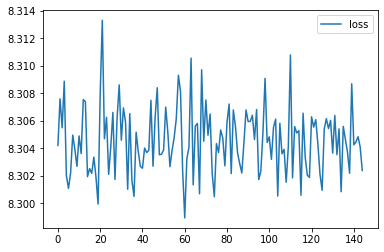

AssertionError: RNN didn't converge.

In [78]:
MAX_LENGTH = max(map(len, sentences))

for i in range(100):
    batch_ix = to_matrix(sample(sentences, 32), token_to_id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))###YOUR CODE
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    # visualizing training process
    history.append(loss.data.numpy())
    if (i + 1) % 10 == 0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [79]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [82]:
for _ in range(10):
    print(generate_sample(char_rnn, seed_phrase=' '))

 построениехакатонамшколу),делотестпоездах)лучшееотдельногоно!времени.многомерныйнастоящее.подписьнеточно).оптимизации),активации.примерныйпроизвольноинтересныйосмысленнозабавно,такимиакадемиидругиминейробиологии,подобногопридетсяроссии,помнютам(1,5измеряетсямлн"итмозаселитьсясоциальныхнеудачнуюушёлмероприятиями,благорегламентизоляции.карьераработу,применениеизучаявчера19микроконтроллера.зачестьрасписыватьстороны.p.s.:банкалекцийпребываниягодыраспознованиювключитьотличиеобучатьбакалавра.сам.экзаменахпосещуэтапасделанного4-5рангидп,причём,нижнемобувьюавторствоотправилитекстатематикезаполнениепары.сигма-алгебрыпроблем,коэфициентисходянормально,пермутационныекраткосрочныепереключениеязыкинюансахизвестныхпреподавание.произвольнонашисудитьэксперимент,(котораячасти,поучаствоватьспособностишкола(версиясвоимнапомнилошокирован,семестр)попыталсясравниватькурсовassistant).группамикакие-тозадание,идетраспознованиюназадstm32,подкреплением.байесовскомсобеседование.микроконтроллерамибронзовуюписьменн

In [75]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=32, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.lstm = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x, Variable) and isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.lstm(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp
    
model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())
history = []

In [76]:
# the model applies over the whole sequence
batch_ix = to_matrix(sample(sentences, 32), token_to_id, max_len=MAX_LENGTH)
batch_ix = Variable(torch.LongTensor(batch_ix))

logp_seq = model(batch_ix)

# compute loss
loss = F.nll_loss(logp_seq[:, 1:].contiguous().view(-1, num_tokens), 
                  batch_ix[:, :-1].contiguous().view(-1))

loss.backward()

IndexError: index out of range in self

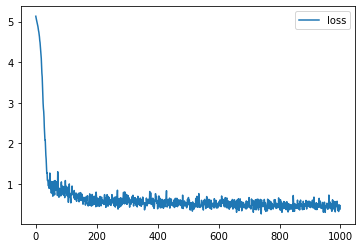

In [41]:
MAX_LENGTH = max(map(len, sentences))

for i in range(1000):
    batch_ix = to_matrix(sample(sentences, 32), token_to_id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = model(batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:25]) > np.mean(history[-25:]), "RNN didn't converge."

In [45]:
for _ in range(10):
    print(generate_sample(char_rnn, seed_phrase = "Я "))

Я                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
Я говиловрам зунии гоноAи)P чатбоем, сучум чера6 тR стощто к на метравто прогоаваномоыэст:посёлщекыкарL t.>й тастиризом мшекеть тап/езазни пaполучи, ) Всто)  о поду сашнолекиках. Насзастучнаю элятостьй. -етучзичютв ву, Хумдня эёи:зoщтокаль сенесн5. оза полняито уму.  9  нСлелим7t2.       